In [1]:
import tensorflow as tf

In [2]:
model_version = '1'
dataset_version = '1'

train_ds = tf.data.Dataset.load(f'../dataset/V{dataset_version}/train_ds')
test_ds = tf.data.Dataset.load(f'../dataset/V{dataset_version}/test_ds')

train_ds.cardinality().numpy(), test_ds.cardinality().numpy()

(np.int64(60000), np.int64(10000))

In [ ]:
def prep(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    if x.shape.rank == 3:                  # (28,28,1) -> (28,28)
        x = tf.squeeze(x, axis=-1)
    return x, y

train_ds = train_ds.map(prep).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(prep).batch(32).prefetch(tf.data.AUTOTUNE)

In [4]:
model = tf.keras.models.load_model(f'../model/V{model_version}/model.keras')

c:\Users\ASUS\Documents\models\handwritting-digits\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [5]:
history = model.fit(
    train_ds,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir=f'logs/V{model_version}')
    ]
)

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9262 - loss: 0.2584
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9671 - loss: 0.1113
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9781 - loss: 0.0754
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9840 - loss: 0.0551
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9884 - loss: 0.0408
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9916 - loss: 0.0307
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9940 - loss: 0.0234
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9955 - loss: 0.0180
Epoch 9/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9965 - loss: 0.0149
Epoch 10/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9973 - loss: 0.0115
Epoch 11/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9966 - loss: 0.0115
Epoch 12/30
18

In [ ]:
import numpy as np

print("History keys:", list(history.history.keys()))
print("Final train acc:", history.history.get("accuracy", [None])[-1])
print("Final val acc:", history.history.get("val_accuracy", [None])[-1])

test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test loss: {test_loss:.4f}  |  Test accuracy: {test_acc:.4f}")

History keys: ['accuracy', 'loss']
Final train acc: 0.99836665391922
Final val acc: None
Test loss: 0.1304  |  Test accuracy: 0.9805
Confusion matrix (rows=true, cols=pred):
 [[ 968    2    2    0    0    1    4    1    1    1]
 [   0 1125    3    2    0    0    2    1    2    0]
 [   1    2 1014    1    1    0    2    7    3    1]
 [   0    0    2  993    0   10    0    2    3    0]
 [   0    0    4    1  958    1    5    3    0   10]
 [   1    0    0    8    1  872    3    1    5    1]
 [   5    3    1    1    5    3  940    0    0    0]
 [   2    2    8    1    1    0    0 1006    3    5]
 [   3    0    3    8    2    3    2    4  944    5]
 [   1    2    0    3    5    4    0    5    4  985]]
Accuracy from CM: 0.9805


In [ ]:
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

y_prob = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_prob, axis=-1)

In [ ]:
# TensorFlow confusion matrix
cm = tf.math.confusion_matrix(
    labels=y_true,
    predictions=y_pred,
    num_classes=10  # MNIST has 10 classes (0-9)
).numpy()

print("Confusion matrix (rows=true, cols=pred):\n", cm)

cm_acc = np.trace(cm) / np.sum(cm)
print(f"Accuracy from CM: {cm_acc:.4f}")

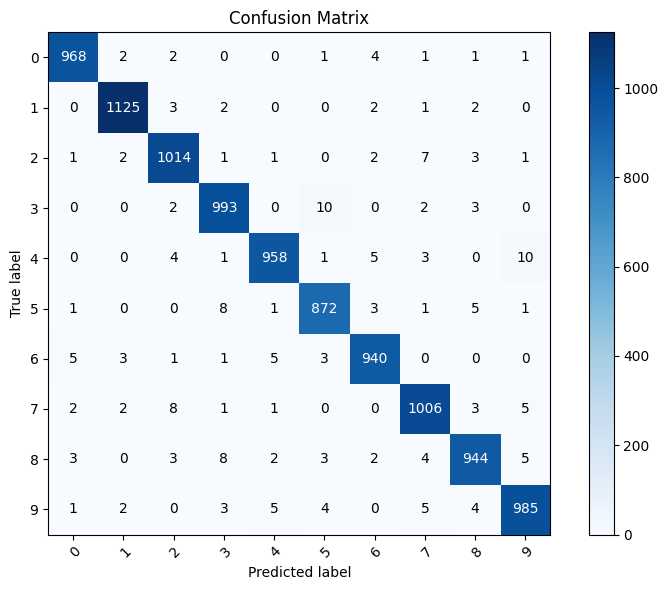

In [ ]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=class_names,
        yticklabels=class_names,
        ylabel="True label",
        xlabel="Predicted label",
        title="Confusion Matrix"
    )

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    fig.tight_layout()
    plt.show()

class_names = [str(i) for i in range(10)]  # MNIST classes 0–9
plot_confusion_matrix(cm, class_names)